Once a model is deployed the feature (covariate) data distribution might shift from that seen during training. These shifts make models go out-of-distribution and worsen their predictions. This paper proposes a simple method to help models adapt to these shifts: minimize the entropy of your predictions. 

That is, before making test-time predictions for a batch, you nudge (SGD) the model to predict peakier (less entropic) class distributions.

Why minimize entropy?

Firstly, because it is convenient. In contrast to other methods, you don't need to modify the training procedure nor require test-time labels. Because labels are rarely available at test time, this makes TENT *"fully test-time"*.

Second, the authors argue that entropy is related to both error and shifts: 

>"Entropy is related to error, as more confident predictions are all-in-all more correct (Figure 1). Entropy is related to shifts due to corruption, as more corruption results in more entropy, with a strong rank correlation to the loss for image classification as the level of corruption increases (Figure 2)."

In [2]:
#| code-summary: Imports and model evaluation function
#| output: false
#| echo: false
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, functools, itertools
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset

from einops import rearrange

from robustbench.utils import load_model
from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel

for d in ['data', 'models', 'logs']: os.makedirs(d, exist_ok = True)

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)

def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == 'cuda':
        print('Setting seed for CUDA')
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed()

def eval_model(model, test, criterion = nn.CrossEntropyLoss()):
    model.to(device)
    model.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
            loss += criterion(model(images), labels).item()
    return loss / len(test.dataset), correct / len(test.dataset)

device

device(type='mps')

To reproduce Figures 1 & 2 we train a ResNet-26 on CIFAR-10 and evaluate its predictions on corrupted versions of the test set to simulate test-time shifts. 

(Note: while the authors also show results for CIFAR-100 and ImageNet, we'll only deal with this small dataset and model for convenience.)

In [2]:
#| code-summary: Datasets
#| output: false

corruption_types = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur',
    'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression'
]

# train_set = datasets.CIFAR10('../data', download = True, train = True,  transform = transforms.ToTensor())
test_set =  datasets.CIFAR10('../data', download = True, train = False, transform = transforms.ToTensor())
n_classes = len(test_set.classes)

def get_test_set(corr_type = 'brightness', data_path = 'data', severity = 5):
    assert 1 <= severity <= 5
    if corr_type in corruption_types:
        X_test, y_test = load_cifar10c(10_000, severity, data_path, False, [corr_type])
        return TensorDataset(X_test, y_test)
    return test_set

def get_cifar10_model(model_path = 'models/cifar10_pretrained'):
    try:
        return torch.load(model_path)
    except:
        m = load_model('Standard', 'models', 'cifar10', ThreatModel.corruptions)
        torch.save(m, model_path)
        return torch.load(model_path)


get_model = lambda: load_model('Standard', 'models', 'cifar10', ThreatModel.corruptions)
model = get_model()

Files already downloaded and verified


/home/ecantuc/.local/lib/python3.12/site-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=to

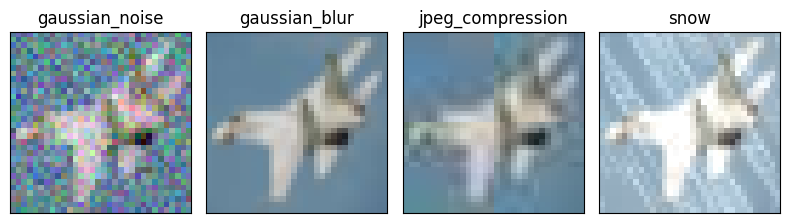

In [19]:
#| echo: false
#| output: true
#| fig-cap: "4 of 15 corruption types included in CIFAR-10-C, shown at the highest severity (5/5) level"

f, axs = plt.subplots(1, 4, figsize = (8, 4))
ix = 10
for ax, corr_type in zip(axs, ['gaussian_noise', 'gaussian_blur', 'jpeg_compression', 'snow']):
    ax.imshow(get_test_set(corr_type)[ix][0].permute(1, 2, 0).numpy())
    ax.set_title(corr_type)
    ax.set_xticks([]); ax.set_yticks([])

f.tight_layout()

In [24]:
#| code-summary: Reproduce Figs 1 & 2

model = get_model()

c, e, l = [], [], []
corruptions, severities = [], []

for corr, severity in itertools.product([None] + corruption_types, range(1, 6)): # 'gaussian_noise', 'gaussian_blur', 'jpeg_compression', 'snow'

    if corr is None and severity > 1: continue
    corrupted_test_set = get_test_set(corr_type = corr, severity = severity)
   
    test = DataLoader(corrupted_test_set, batch_size = 128, shuffle = False)

    model.to(device); model.eval()
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            _, pred = torch.max(logits, 1)
            correct = (pred == labels).float()
            entropy = -(logits.softmax(dim = 1) * logits.log_softmax(dim = 1)).sum(dim = 1)
            loss = nn.CrossEntropyLoss(reduce = False)(logits, labels)
            c.append(correct)
            e.append(entropy)
            l.append(loss)
            corruptions.extend([corr] * len(correct))
            severities.extend([severity] * len(correct))

correct = torch.cat(c).cpu().numpy()
entropy = torch.cat(e).cpu().numpy()
loss    = torch.cat(l).cpu().numpy()

/home/ecantuc/.local/lib/python3.12/site-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=to

/tmp/ipykernel_3777877/2275027765.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Corruption'].replace({
/tmp/ipykernel_3777877/2275027765.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('Entropy')['Error'].mean().reset_index()


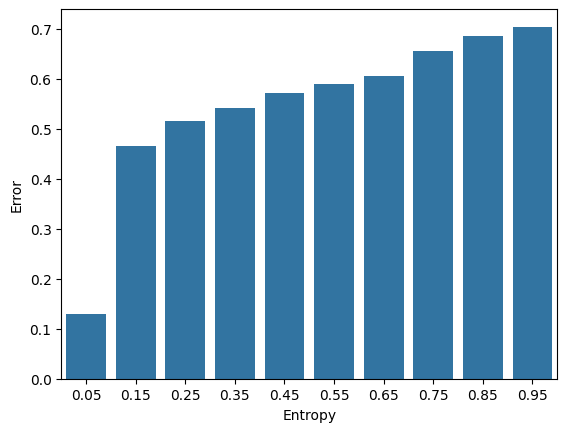

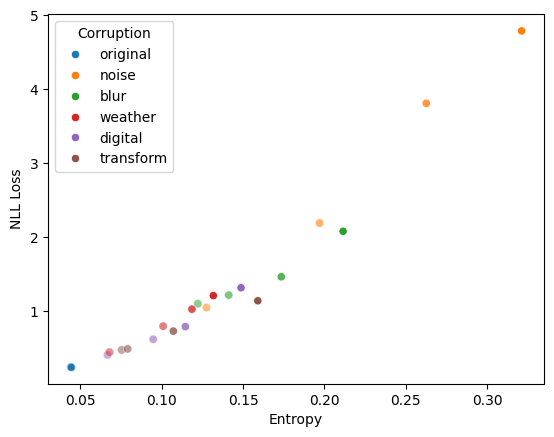

In [30]:
#| echo: false
#| layout-ncol: 2
#| label: fig-1-2
#| fig-cap: 
#|   - "Preds with less entropy have lower error rates."
#|   - "More corruption (shown as alpha) leads to higher loss and entropy."

df = pd.DataFrame({
    'Entropy': entropy, 'correct': correct, 'Loss': loss,
    'Corruption': corruptions, 'Severity': severities
})
df['Corruption'].replace({
    None: 'original',
    'pixelate': 'digital', 'jpeg_compression': 'digital',
    'snow': 'weather', 'frost': 'weather', 'fog': 'weather',
    'brightness': 'digital', 'contrast': 'digital', 'elastic': 'digital'
}, inplace = True)
df['Corruption'] = df['Corruption'].apply(lambda s: s.split('_')[1] if len(s.split('_')) > 1 else s)

tmp = df.copy()
tmp['Entropy'] = pd.cut(tmp['Entropy'], bins = np.linspace(0, 1, 11))
tmp['Error'] = 1 - tmp['correct']

tmp = tmp.groupby('Entropy')['Error'].mean().reset_index()
tmp['Entropy'] = tmp['Entropy'].apply(lambda x: x.mid)
tmp['Entropy'] = [str(round(i, 3)) for i in tmp['Entropy'].to_list()]
sns.barplot(x = 'Entropy', y = 'Error', data = tmp)
plt.show()

plt.figure()
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]
h_order = df['Corruption'].unique() #None#['original', 'gaussian_noise', 'gaussian_blur', 'jpeg_compression', 'snow']

ax = sns.scatterplot(
    data = df[(df['Severity'] == 1) & (df['Corruption'] != 'original')].groupby(['Corruption']).mean(),
    x = 'Entropy', y = 'Loss', hue = 'Corruption', alpha = alphas[0], legend = False, hue_order = h_order,
)

sns.scatterplot(
    data = df[(df['Severity'] == 1) & (df['Corruption'] == 'original')].groupby(['Corruption']).mean(),
    x = 'Entropy', y = 'Loss', hue = 'Corruption', alpha = 1.0, legend = False, hue_order = h_order, ax = ax,
)

for i, alpha in enumerate(alphas):

    sns.scatterplot(
        data = df[df['Severity'] == i].groupby(['Corruption']).mean(),
        x = 'Entropy', y = 'Loss', hue = 'Corruption', alpha = alpha, ax = ax, legend = i == len(alphas) - 1, hue_order = h_order,
    )

_ = ax.set_ylabel('NLL Loss')

The intuition here as far as I can tell is that entropy encodes the model's confidence. If the model's prediction is confident it is *all-in-all* more probable to be correct (it might have seen similar examples during training, the example might be "easy", etc). Corruptions take the model OOD and decrease its confidence. Since cross-entropy is lowest when all probability mass is assigned to the correct label, increasing entropy (all-in-all) dilutes that mass and increases loss. 


Two important notes on *how* entropy is minimized:

First, the authors note that once we switch the model to entropy minimization we run the risk of causing it to deviate from its training. While you could choose a sufficiently small learning rate or add KL regularization to alleviate this, the authors opt for freezing most of the model and only updating the learnable parameters in the batch norm layers.

Second, we must use batches. If we minimize single examples we'll just assign all of the mass to the most likely class. 

/tmp/ipykernel_1622818/1116078655.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_path)


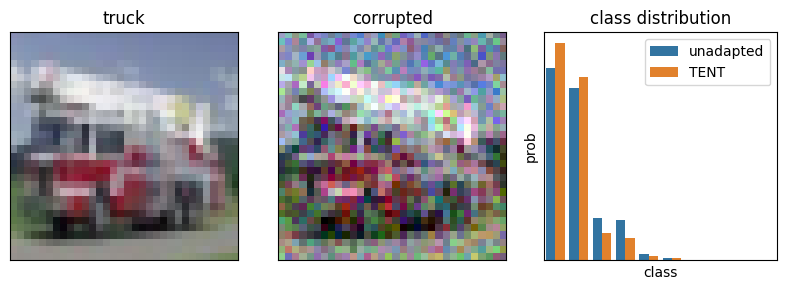

In [25]:
#|code-summary: TENT example
#| label: fig-demo
#| fig-cap: "TENT produces class distributions with less entropy, concentrating mass in fewer classes."


# Only update BN layers
def prepare_for_test_time(module, reset_stats = True):
    if isinstance(module, nn.BatchNorm2d):
        if reset_stats: module.reset_running_stats()
        module.requires_grad = True
    else: module.requires_grad = False 

    for m in module.children(): prepare_for_test_time(m, reset_stats)


# Init the model & optimizer
model = get_cifar10_model(); model.to(device)
corr_test_set = get_test_set(corr_type = 'gaussian_noise', severity = 5)
model.apply(functools.partial(prepare_for_test_time, reset_stats = False))
optimizer = optim.AdamW(model.parameters(), lr = 0.00001)

# Get a batch of corrupted images
images, labels = next(iter(DataLoader(corr_test_set, batch_size = 128)))
images, labels = images.to(device), labels.to(device)

# Minimize entropy
model.train()
optimizer.zero_grad()
preds = model(images)
entropy = -(preds.softmax(dim = 1) * preds.log_softmax(dim = 1)).sum(dim = 1)
loss = entropy.mean()
loss.backward()
optimizer.step()

new_preds = model(images)

# Plot
f, axs = plt.subplots(1, 3, figsize = (8, 3))
ix = 89
axs[0].imshow(test_set[ix][0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title(test_set.classes[test_set[ix][1]])
axs[0].set_xticks([]); axs[0].set_yticks([])

axs[1].imshow(images[ix].permute(1, 2, 0).cpu().numpy())
axs[1].set_title('corrupted')
axs[1].set_xticks([]); axs[1].set_yticks([])

order = torch.argsort(preds.softmax(dim = 1)[ix]).detach().cpu().numpy()[::-1]
rows = [{'class': i, 'prob':p, 'type': 'unadapted'} for i, p in enumerate(preds.softmax(dim = 1)[ix].detach().cpu().numpy()[order])]
rows.extend([{'class': i, 'prob':p, 'type': 'TENT'} for i, p in enumerate(new_preds.softmax(dim = 1)[ix].detach().cpu().numpy()[order])])
sns.barplot(x = 'class', y = 'prob', hue = 'type', data = pd.DataFrame(rows), ax = axs[2])
axs[2].set_title('class distribution')
axs[2].legend()
axs[2].set_xticks([]); axs[2].set_yticks([])

f.tight_layout()

Now for evaluation. While the authors consider other baselines, for simplicity, we only compare TENT against the unadapted source model and a test-time normalization [method](https://arxiv.org/abs/2006.16971) which just updates the BN statistics during testing. 

In [ ]:
#| code-summary: Eval unadapted model
#| output: false
def eval_source(init_model_fn, severity = 5, batch_size = 128):
    model = init_model_fn(); model.to(device)
    results = {}
    for corr_type in corruption_types:
        corr_test_set = get_test_set(corr_type = corr_type, severity = severity)
        _, source_acc = eval_model(model, DataLoader(corr_test_set, batch_size = batch_size))
        results[corr_type] = 1 - source_acc
    return results

source_results = eval_source(get_model)
torch.save(source_results, 'logs/source_results')

In [ ]:
#|code-summary: Eval Norm
#|output: false
def reset_bn_stats(module):
    if isinstance(module, nn.BatchNorm2d):
        module.reset_running_stats()
    for m in module.children(): reset_bn_stats(m)


@torch.no_grad()
def eval_norm(init_model_fn, severity = 5, batch_size = 128, reset_stats = False, corr_types = None):

    results_acc = {}
    if corr_types is None: corr_types = [None] + corruption_types
    for corr_type in corr_types:
        print(corr_type)
        
        model = init_model_fn(); model.to(device)  # Re-init the model
        if reset_stats: model.apply(reset_bn_stats)
        corr_test_set = get_test_set(corr_type = corr_type, severity = severity)

        for i, (images, labels) in enumerate(DataLoader(corr_test_set, batch_size = batch_size)):
            images, labels = images.to(device), labels.to(device)

            # Update the BN stats
            model.train()
            preds = model(images.to(device))

            err = (torch.max(preds, 1)[1] != labels).float().sum().item() / labels.shape[0]
            results_acc[corr_type] = results_acc.get(corr_type, []) + [err]
            if i % 15 == 0: print(err)
        
    return results_acc

norm_results = eval_norm(get_cifar10_model, reset_stats = False)
torch.save(norm_results, 'logs/norm_results_all')

In [10]:
#|code-summary: Eval TENT
#| output: false
# Only update BN layers
def prepare_for_test_time(module, reset_stats = True):
    if isinstance(module, nn.BatchNorm2d):
        if reset_stats: module.reset_running_stats()
        module.requires_grad = True
    else: module.requires_grad = False 

    for m in module.children(): prepare_for_test_time(m, reset_stats)

def eval_tent(init_model_fn, severity = 5, lr = 0.001, batch_size = 128, reset_stats = True, corr_types = None):

    results_acc = {}
    results_e = {}
    if corr_types is None: corr_types = [None] + corruption_types

    for corr_type in corr_types:
        print(corr_type)

        # Re-init the model & optimizer
        model = init_model_fn(); model.to(device)
        corr_test_set = get_test_set(corr_type = corr_type, severity = severity)
        model.apply(functools.partial(prepare_for_test_time, reset_stats = reset_stats))
        optimizer = optim.AdamW(model.parameters(), lr = lr)

        corr_test_set = get_test_set(corr_type = corr_type, severity = severity)

        for i, (images, labels) in enumerate(DataLoader(corr_test_set, batch_size = batch_size)):
            images, labels = images.to(device), labels.to(device)

            # Minimize entropy
            model.train()
            optimizer.zero_grad()
            preds = model(images)
            entropy = -(preds.softmax(dim = 1) * preds.log_softmax(dim = 1)).sum(dim = 1)
            loss = entropy.mean()
            loss.backward()
            optimizer.step()

            err = (torch.max(preds, 1)[1] != labels).float().sum().item() / labels.shape[0]
            results_acc[corr_type] = results_acc.get(corr_type, []) + [err]
            results_e[corr_type] = results_e.get(corr_type, []) + [loss.item()]
            if i % 15 == 0: print(err)

    return results_acc, results_e


# tent_acc, tent_entropy = eval_tent(get_cifar10_model, reset_stats = False, lr = 0.00001)
# torch.save(tent_acc, 'logs/tent_acc'); torch.save(tent_entropy, 'logs/tent_entropy')

# tent_acc_r, tent_entropy_r = eval_tent(get_model, reset_stats = True, lr = 0.00001)
# torch.save(tent_acc_r, 'logs/tent_acc_r'); torch.save(tent_entropy_r, 'logs/tent_entropy_r')

/tmp/ipykernel_1622818/3901032139.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  source_results = torch.load('logs/source_results')
/tmp/ipykernel_1622818/3901032139.py

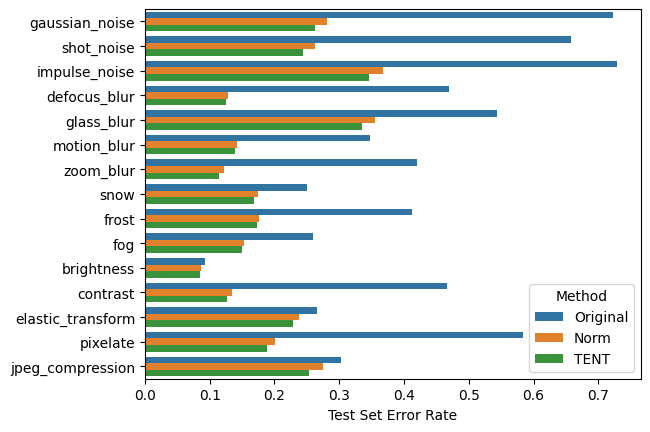

In [26]:
#| echo: false
#| label: fig-results
#| fig-cap: "TENT & Norm consistently outperform the unadapted model, with TENT (lr = 1e-5, batch_size = 128) taking a slight lead."

source_results = torch.load('logs/source_results')
norm_results = torch.load('logs/norm_results_all')
tent_acc = torch.load('logs/tent_acc_all')
tent_acc_r = torch.load('logs/tent_acc_r_all')

df = []
for corr in source_results:
    df.append({'Corruption': corr, 'Method': 'Original', 'Error Rate': source_results[corr]})
    df.append({'Corruption': corr, 'Method': 'Norm', 'Error Rate': np.mean(norm_results[corr])})
    df.append({'Corruption': corr, 'Method': 'TENT', 'Error Rate': np.mean(tent_acc[corr])})

df = pd.DataFrame(df)
sns.barplot(data = df, y = 'Corruption', x = 'Error Rate', hue = 'Method')
plt.ylabel(''); plt.xlabel('Test Set Error Rate')

In [9]:
#| output: false
#| echo: false
df.groupby('Method')['Error Rate'].mean()

Method
Norm        0.206566
Original    0.435133
TENT        0.196064
Name: Error Rate, dtype: float64

In [11]:
#| code-summary: Hyperparam grid
#| output: false
grid_results = {}
for lr, b in itertools.product([1e-4, 1e-5, 1e-6], range(4, 9)):
    batch_size = int(2 ** b)
    print(lr, batch_size)
    tent_acc, tent_entropy = eval_tent(get_cifar10_model, reset_stats = False, lr = lr, batch_size = batch_size, corr_types = ['gaussian_noise'])
    grid_results[(lr, batch_size)] = (tent_acc, tent_entropy)

torch.save(grid_results, 'logs/grid_results_all')

grid_results_norm = {}
for b in range(4, 9):
    batch_size = int(2 ** b)
    print(batch_size)
    acc = eval_norm(get_cifar10_model, reset_stats = False, batch_size = batch_size, corr_types = ['gaussian_noise'])
    grid_results_norm[(batch_size)] = acc

torch.save(grid_results_norm, 'logs/grid_results_norm')

0.0001 16
gaussian_noise


/tmp/ipykernel_2138226/1116078655.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_path)


0.3125
0.375
0.3125
0.375
0.5
0.625
0.8125
0.5625
0.875
0.9375
0.9375
0.8125
0.75
0.75
0.625
0.625
0.8125
0.6875
0.8125
0.8125
0.8125
0.875
0.9375
0.5
0.8125
0.8125
0.875
0.8125
0.8125
0.8125
0.5625
0.8125
0.8125
0.875
0.6875
0.8125
0.75
0.75
0.8125
0.875
0.75
0.8125
0.0001 32
gaussian_noise
0.21875
0.15625
0.34375
0.5
0.46875
0.375
0.40625
0.375
0.46875
0.5625
0.4375
0.5625
0.5
0.78125
0.5
0.59375
0.75
0.78125
0.8125
0.78125
0.84375
0.0001 64
gaussian_noise
0.25
0.359375
0.4375
0.3125
0.375
0.40625
0.5
0.5
0.625
0.609375
0.578125
0.0001 128
gaussian_noise
0.25
0.3671875
0.2734375
0.4140625
0.3828125
0.296875
0.0001 256
gaussian_noise
0.26953125
0.27734375
0.32421875
1e-05 16
gaussian_noise
0.3125
0.125
0.25
0.1875
0.375
0.25
0.5625
0.3125
0.4375
0.3125
0.5
0.375
0.25
0.125
0.125
0.25
0.1875
0.1875
0.125
0.4375
0.125
0.125
0.25
0.3125
0.25
0.375
0.25
0.3125
0.25
0.4375
0.375
0.3125
0.4375
0.375
0.3125
0.5
0.4375
0.3125
0.4375
0.125
0.25
0.1875
1e-05 32
gaussian_noise
0.21875
0.125
0.21

The paper shows TENT having more of a lead on this dataset, but this is the best I could do.

How sensitive is it to hyperparameters? TENT has two: the test-time learning rate and batch size. We vary these and show results for the `gaussian_noise` corruption.

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_12390/3553206148.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  grid_results      = torch.load('logs/grid_res

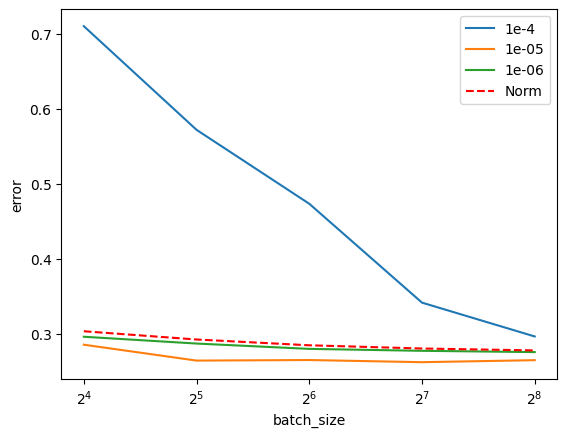

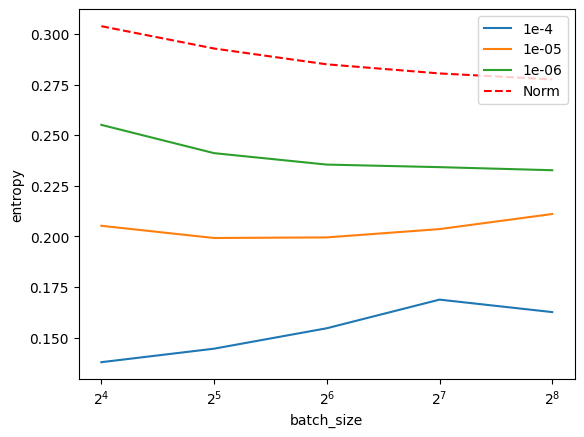

In [9]:
#| echo: false
#| layout-ncol: 2
#| label: fig-grid
#| fig-cap: 
#|   - "TENT consistently outperforms other methods across corruption types."
#|   - "Mean entropy over test set"

grid_results      = torch.load('logs/grid_results_all')
grid_results_norm = torch.load('logs/grid_results_norm')

rows = []
for (lr, batch_size), (test_acc, test_entropy) in grid_results.items():

    rows.append({
        'lr': lr, 'batch_size': batch_size, 'error': np.mean(test_acc['gaussian_noise']),
        'entropy': np.mean(test_entropy['gaussian_noise'])
    })

grid = pd.DataFrame(rows)
grid['lr'] = grid['lr'].astype('str')
grid['lr'].replace({'0.0001': '1e-4'}, inplace = True)

sns.lineplot(data = grid, x = 'batch_size', y = 'error', hue = 'lr')
plt.plot(
    list(grid_results_norm.keys()), [np.mean(acc['gaussian_noise']) for (acc, e) in grid_results_norm.values()],
    'r--', label = 'Norm'
    )
plt.legend()
plt.xticks(grid['batch_size'].unique())
plt.xscale('log', base = 2)
plt.figure()

sns.lineplot(data = grid, x = 'batch_size', y = 'entropy', hue = 'lr')
plt.plot(
    list(grid_results_norm.keys()), [np.mean(e['gaussian_noise']) for (acc, e) in grid_results_norm.values()],
    'r--', label = 'Norm'
    )
plt.legend()
plt.xticks(grid['batch_size'].unique())
plt.xscale('log', base = 2)

TENT seems quite sensitive to hyperparameters, a [common challenge](https://arxiv.org/abs/2306.03536) to all Test-Time Adaptation methods. 

Wrapping up, TENT is a compelling TTA method. You can use a pre-trained model and don't require test-time labels. Some challenges are that it is limited to classification, is [not well-suited for calibrated](https://arxiv.org/pdf/2410.10894v1) (makes models overconfident) or online learning (we need batches), and is sensitive to hyperparameters. 


*All-in-all* it was an interesting paper and introduced me to the test-time adaptation literature. 